In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import quad
import itertools
import copy
from image_matrix_helper import compute_master_list, imshow_list, rgb_map, color_to_rgb, list_to_matrix
import random
import time

nb_start = time.time()

## Simulation for the Simple Particle Binding Model


In this notebook, we simulate a thermal system of particles of various colors binding onto a grid. We have $R$ different types of particles and particle of type $j$ has $n_j$ copies in the system. Particles can exist both on and off the grid and particles of type $j$ have a binding affinity of $\gamma_j$ to the grid. Here we want to use simulations of this system to affirm analytical calculations of the average number of bound particles.


### Numerical representations of analytical work

#### System Partition Function 

The partition function for this system is 

\begin{equation}
W_{\boldsymbol{n}}(\{\gamma_i\}) = \frac{1}{2\pi i}  \oint \frac{dz}{z} \,e^{z}\prod_{i=1}^{R}\left(\gamma_i + \frac{1}{z}\right)^{n_i},
\label{eq:Wdef0}
\end{equation}

*It would be convenient to represent this result numerically and use it to compute the exact expression for $\langle k \rangle$, but Python's numerical complex integration abilities are limited.*

In [2]:
# gamma function definition
gamma_func = lambda E0, Ev, T: 4*np.sqrt(2)*np.exp(E0/T)*(Ev/T)**(3/2)

In [3]:
## test values
R = 50
E0s = 4.15*np.ones(R)
Evs = 1e-3*np.ones(R)
Nelems = np.ones(R)
T0 = 0.2

#### Thermal limits of disorder

At what temperature, will all the ligands in the be be attached to a receptor. $\langle k \rangle$ representing the number of ligands bound to receptors, at what temperature does the system settle into the macrostate  $\langle \ell_{\text{tot}}\rangle = N$?"

We found that this temperature $\beta_c = 1/k_BT_c$ is defined implicitly by 

$$ 1 = \sum_{j=1}^R n_j \gamma_{j}^{-1} $$ 

In [4]:
# implicit thermal constraint

def ligand_bind_constr(beta, E0s, Evs, Ns):
    
    gammas_ = gamma_func(E0s, Evs, beta**(-1))
    
    F =  1-np.sum(Ns*gammas_**(-1))
    
    return F

# critical temperature
kBTcrit = lambda E0s, Evs, Ns: 1.0/fsolve(ligand_bind_constr, x0 = 0.5, args = (E0s, Evs, Ns))[0]

# Test function 
kBTcrit(E0s, Evs, Nelems)

0.3749141536398384

#### Equations of Large $N$ approximation 

The order parameter can be approximated as 
\begin{align}
\langle k \rangle & =   \sum_{j=1}^R \frac{n_j \gamma_j \bar{z}}{\gamma_j \bar{z} +1},
\end{align}
where $\bar{z}$ is defined from 
\begin{equation}
\bar{z} = \sum_{j=1}^{R} \frac{n_j}{\bar{z} \gamma_j+1}.
\end{equation}

#### Analytical Approximation

In [5]:
# function that determines xbar
def zbar_func(z, T, E0s, Evs, Ns):
    
    F = np.ones(2)
    R = len(Ns)
    
    gammas_ = gamma_func(E0s, Evs, T)
    
    F = z- np.sum(Ns/(z*gammas_+1))
                     
    return F

# function that determs k_avg for large N
def avg_k_approx(T, E0s,  Evs, Ns):
    
    R = len(Ns)
    zbar = fsolve(zbar_func, x0 = (110), args = (T, E0s, Evs, Ns))

    gammas_ = gamma_func(E0s, Evs, T)
    
    k_js = Ns*zbar*gammas_/(zbar*gammas_+1)
    
    return np.sum(k_js)
        

#### Example analytical plot

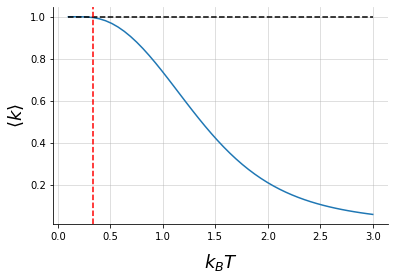

In [6]:
# parameters for the integral
np.random.seed(42)

# temperature vals
Tvals = np.linspace(0.1, 3.0, 50)

R = 50
sigma_E = 1.5
E0bar = 6.15
E0s = np.random.randn(R)*sigma_E+E0bar
Nelems = np.random.randint(1,10,R)
Evs = np.ones(R)*0.001
avg_k_approx_vals = [avg_k_approx(T, E0s, Evs, Nelems)/np.sum(Nelems) for T in Tvals]

## plotting order parameters
ax = plt.subplot(111)
ax.plot(Tvals, avg_k_approx_vals, label = r"$\langle k \rangle/N$")
ax.plot(Tvals, np.ones(len(Tvals)), 'k--')

ax.set_ylabel(r'$\langle k \rangle$', fontsize = 18)
ax.set_xlabel(r'$k_BT$', fontsize = 18, labelpad = 10.5)
ax.grid(alpha = 0.5)
ax.axvline(x = kBTcrit(E0s, Evs, Nelems), color = 'r', linestyle = '--')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

### Metropolis Hastings simulation code 

#### Microstate transitions

In [7]:
## dissociation operator
def trans_dissoc(free_objs, bound_objs):
        
        # indices of non-empty
        indxs = [i for i, x in enumerate(bound_objs) if x != "-"]
        
        # random choice for bound object
        random_indx = random.choice(indxs)

        ## new state vector 
        free_objs_new = copy.deepcopy(free_objs)
        bound_objs_new = copy.deepcopy(bound_objs)

        # putting empty slot
        bound_objs_new[random_indx] = '-'
        # appending previously bound object to free objects
        free_objs_new.append(bound_objs[random_indx])

        return free_objs_new, bound_objs_new


## association operator
def trans_assoc(free_objs, bound_objs):
    
        # random element to associate
        elem = random.choice(free_objs)

        # indices of empty spaces
        indxs = [i for i, x in enumerate(bound_objs) if x == "-"]  

        # random choice for empty space
        random_indx = random.choice(indxs)

        ## new state vector 
        free_objs_new = copy.deepcopy(free_objs)
        bound_objs_new = copy.deepcopy(bound_objs)    

        ## state
        free_objs_new.remove(elem)
        bound_objs_new[random_indx] = elem      

        return free_objs_new, bound_objs_new

#### Logarithm of Botlzmann factor

The logarithm of the Botlzmann factor for a microstate (i.e., the temperature normalized negative energy of the microstate) is defined as 

\begin{equation}
\beta E(\boldsymbol{k}) = \sum_{i=1}^R k_i \ln \gamma_i.
\label{eq:sim_en}
\end{equation}

In [8]:
def log_boltz(free_objs, bound_objs, mstr_vec,  gammas, name_key):
    
    elem_set = list(set(mstr_vec))
    count_dict = dict()
    for elem in elem_set:
        count_dict[elem] = bound_objs.count(elem)

    bind_log_factor = 0
    for elem in elem_set:
        key = name_key[elem]
        bind_log_factor += count_dict[elem]*np.log(gammas[key])
    
    return bind_log_factor

#### Checking logarithm of Boltzmann factor definition

In [9]:
# defining name key
name_key0 = dict()
key_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', ]
for j in range(len(key_list)):
    name_key0[key_list[j]] = j
    
# random energies    
np.random.seed(2)
q1 = np.random.rand(10)

# sample master list
orig_free = ['F', 'G', 'H', 'I', 'J']
orig_bound = ['A', 'B', 'C', 'D', 'E', '-','-','-','-','-']
sample_master = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

print('Energy for original ordering:', log_boltz(orig_free, orig_bound, sample_master, np.exp(-q1), name_key0))
print('Checking energy value:', -np.sum([q1[k] for k in range(len(sample_master)) if sample_master[k] in orig_bound]))
print('Number of bound elements:', np.sum([1 for elem in orig_bound if elem!='-']))
print('-----')
new_free, new_bound = trans_dissoc(orig_free, orig_bound)
print('Energy after switching first and last values:', log_boltz(new_free, new_bound, sample_master, np.exp(-q1), name_key0))
print('Checking energy value:', -np.sum([q1[k] for k in range(len(sample_master)) if sample_master[k] in new_bound]))
print('Number of bound elements:',  np.sum([1 for elem in new_bound if elem!='-']))

Energy for original ordering: -1.8672738065543701
Checking energy value: -1.86727380655437
Number of bound elements: 5
-----
Energy after switching first and last values: -1.4312789044123664
Checking energy value: -1.4312789044123664
Number of bound elements: 4


#### Metropolis Hastings algorithm

In [10]:
### Metropolis Monte Carlo Algorithm 

## loads uniform random sampling 
runif = np.random.rand

def met_assembly_grid(Niter, free_objs, bound_objs, mstr_vec, gammas, name_key):
    '''
    #################################################################
    # function to sample using Metropolis 
    #  
    # n_iter:  number of iterations
    # initial_state: initial state for the start position for our chain
    # gamma: energy cost for incorrect component
    # temp: temperature 
    ##################################################################
    '''
    
    # Initialize state values
    free_objs_vals = [0]*(Niter+1)
    bound_objs_vals = [0]*(Niter+1)
    
    # Set initial values
    free_objs_vals[0] = free_objs[:]
    bound_objs_vals[0] = bound_objs[:]
        
    # Initialize acceptance counts
    # We can use this to tune our number of steps
    accepted = 0
    
    for i in range(Niter):
    
        # get current monomer and dimer states
        current_free_objs = copy.deepcopy(free_objs_vals[i])
        current_bound_objs = copy.deepcopy(bound_objs_vals[i])
        
        N_free = len(current_free_objs)
        N_bound = len(current_bound_objs)-len(current_free_objs)
        
        u_trans = runif()
        
        if u_trans < 1/2: #first type of transition; monomer association 
            
            if N_free < 1:
                
                log_alpha = np.log(1e-15) 
            
            else:
                # proposed new monomer and dimer states
                new_free_objs, new_bound_objs = trans_assoc(current_free_objs, current_bound_objs)

                # transition elements
                log_init = log_boltz(current_free_objs, current_bound_objs, mstr_vec, gammas, name_key)
                log_final = log_boltz(new_free_objs, new_bound_objs, mstr_vec, gammas, name_key)

                # testing weight
                num = N_free*N_free
                den = N_bound+1

                # Log-acceptance rate
                log_alpha = log_final-log_init+np.log(num/den) 
            
        elif 1/2 <= u_trans : #second type of transition; bound monomer dissociation
            
            if N_bound <1:
                
                log_alpha = np.log(1e-15) 
                
            else: 
                
                # proposed new monomer and dimer states
                new_free_objs, new_bound_objs = trans_dissoc(current_free_objs, current_bound_objs)

                # transition elements
                log_init = log_boltz(current_free_objs, current_bound_objs, mstr_vec,  gammas, name_key)
                log_final = log_boltz(new_free_objs, new_bound_objs, mstr_vec, gammas, name_key)

                # testing weight
                num = N_bound 
                den = (N_free+1)*(N_free+1)              
                
                # Log-acceptance rate
                log_alpha = log_final-log_init+np.log(num/den)
            
        # Sample a uniform random variate
        u = runif()

        # Test proposed value
        if np.log(u) < log_alpha:
            # Accept
            free_objs_vals[i+1] = new_free_objs
            bound_objs_vals[i+1] = new_bound_objs
            
            #log_current_prob = log_proposed_prob
            accepted += 1
        else:
            # Stay put
            free_objs_vals[i+1] = free_objs_vals[i]
            bound_objs_vals[i+1] = bound_objs_vals[i]

    # return our samples and the number of accepted steps
    return free_objs_vals, bound_objs_vals, accepted

#### Computing microstate average from simiulations

In [11]:
def avg_k(bound_objs_vals, Nmc):
    
    """
    Microstate average of number of bound objects
    We only consider microstates near the end of theh chain to ensure
    that the system has equilibrated
    """
    
    length = int(Nmc/50)
    
    ls = [0]*length
    ls = np.array(ls)
    for k in range(length):
        ls[k] = len(bound_objs_vals[Nmc-length+k]) - bound_objs_vals[Nmc-length+k].count('-')
    
    return(np.mean(ls))

#### Image grid for completely correct configuration

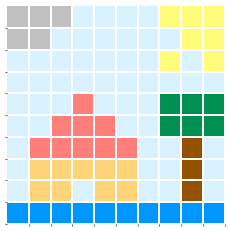

In [12]:
# defining master_list
master_list =compute_master_list()
# testing plot
imshow_list(master_list)
# defining Nelems
Nelems = np.zeros(8)
key_list = list(rgb_map.keys())[:-1]
name_key_ = dict()
for j in range(len(key_list)):
    name_key_[key_list[j]] = j
    Nelems[j] = master_list.count(key_list[j])

In [13]:
# displaying copy-number counts of the various elements
Nelems

array([ 9.,  9., 10.,  5.,  7.,  6.,  3., 51.])

#### Simulating system

In [14]:
## Generate lf for each temperature from .03 to 2.0 in npoints steps

t0 = time.time()

# number of steps for MC algortihm
Nmc = 10000
    
# binding energy parameters
R = 8
E0_bar, sigma_E = 6.0, 2.0
E0s = np.random.randn(R)*sigma_E+E0_bar
Evs = np.ones(R)*0.001

# initial monomer and dimer states; 
# system in microstate of all correct dimers
random.seed(0)
free_objs_0 = []
bound_objs_0 = random.sample(master_list, len(master_list))
mstr_vec = copy.deepcopy(master_list)

# temperature limits
Tmin = .05
Tmax = 3.0

npoints = 15 #number of temperature values
navg = 5 # number of times we run simulation at each temperature; 50 in paper
temp_vals = np.linspace(Tmin, Tmax, npoints).tolist()

# list of dimer values 
sim_k_vals = [0]*npoints

# accepted list 
accepted_list = [0]*npoints

# saved list for plotting
saved_list = dict()

for k in range(npoints):
    
    fin_k_vals = [0]*navg
    fin_accepted = [0]*navg
    
    for j in range(navg): 
        
        # make copy of initial monomer and dimer states 
        free_objs_copy = copy.deepcopy(free_objs_0)
        bound_objs_copy = copy.deepcopy(bound_objs_0)
        
        # defining helper functions
        gammas_ = gamma_func(E0s, Evs, temp_vals[k])

        # metroplois generator
        free_list, bound_list, accepted = met_assembly_grid(Nmc, 
                                                            free_objs_copy,
                                                            bound_objs_copy,
                                                            mstr_vec,
                                                            gammas_, 
                                                            name_key_) 
        
        

        
        # averaging final states to compute observables
        fin_k_vals[j] = avg_k(bound_list, Nmc)
        fin_accepted[j] = accepted
    
    # saving every 5 temperatures
    if (k+1)%5 ==0 or k ==0:
        saved_list[k] = ['white' if x=='-' else x for x in bound_list[-1]]   
    
    # averaging over computed equilibrium averages
    sim_k_vals[k] = np.mean(np.array(fin_k_vals))
    accepted_list[k] = np.mean(np.array(fin_accepted))
    
    t_prelim = time.time()
    print("Temperature Run:",str(k+1),"; Current Time:", round(t_prelim-t0,2),"secs")
    

t1 = time.time()
print("Total Simulation Run Time:",t1-t0,"secs")

Temperature Run: 1 ; Current Time: 5.93 secs
Temperature Run: 2 ; Current Time: 10.95 secs
Temperature Run: 3 ; Current Time: 19.29 secs
Temperature Run: 4 ; Current Time: 29.63 secs
Temperature Run: 5 ; Current Time: 41.04 secs
Temperature Run: 6 ; Current Time: 54.38 secs
Temperature Run: 7 ; Current Time: 67.18 secs
Temperature Run: 8 ; Current Time: 80.79 secs
Temperature Run: 9 ; Current Time: 95.19 secs
Temperature Run: 10 ; Current Time: 109.09 secs
Temperature Run: 11 ; Current Time: 123.55 secs
Temperature Run: 12 ; Current Time: 139.58 secs
Temperature Run: 13 ; Current Time: 154.84 secs
Temperature Run: 14 ; Current Time: 169.51 secs
Temperature Run: 15 ; Current Time: 184.19 secs
Total Simulation Run Time: 184.18926906585693 secs


#### Simulated image grid at various temperatures

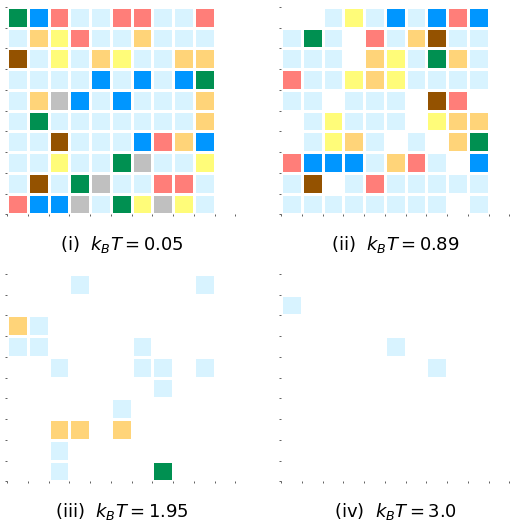

In [15]:
# figure parameters
rows, cols, idx = 2, 2, 0
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(9,9))

# list of keys for saved snapshots of image
img_key_list = list(saved_list.keys())

for i in range(rows):
    for j in range(cols):
        if idx < 4:
            axes[i, j].imshow(color_to_rgb(list_to_matrix(saved_list[img_key_list[idx]])))
            ax = plt.gca()
            
            # making ticks invisible
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            # Minor ticks
            axes[i, j].set_xticks(np.arange(-0.5, 11, 1), minor=True)
            axes[i, j].set_yticks(np.arange(-0.5, 10, 1), minor=True)
            axes[i, j].tick_params(axis='y', colors='red')
            
            # labeling images
            itimes = 'i'*(1+idx) if idx<3 else 'iv'
            
            # Gridlines based on minor ticks
            axes[i, j].grid(which='minor', color='w', linestyle='-', linewidth=3)
            axes[i, j].set_title(fr'({itimes})  $k_BT = {round(temp_vals[img_key_list[idx]],2)}$', fontsize = 18, y = -.2)

            # making spines invisible
            axes[i, j].spines['right'].set_visible(False)
            axes[i, j].spines['top'].set_visible(False)
            axes[i, j].spines['left'].set_visible(False)
            axes[i, j].spines['bottom'].set_visible(False)   
            
            idx +=1
    
# plt.savefig('binding_grid_assembly_grid_plots.png', bbox_inches='tight', format = 'png')    
plt.show()

#### Comparing analytical and simulation results

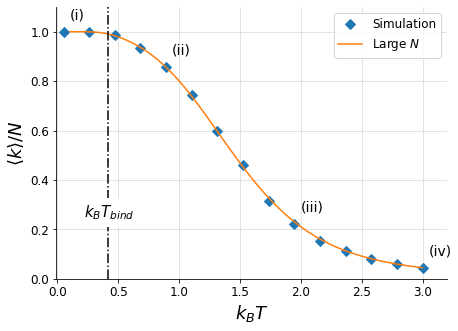

In [16]:
plt.figure(figsize = (7,5))
ax = plt.subplot(111)

# plot of simulation results
plt.plot(temp_vals,np.array(sim_k_vals)/np.sum(Nelems), 
        label = f'Simulation',
        markersize = 7.5,
       marker = 'D',
       linestyle = '')

# plot of large N analytical results
k_avg_approx_vals = [avg_k_approx(T, E0s, Evs, Nelems)/np.sum(Nelems) for T in Tvals]
plt.plot(Tvals, k_avg_approx_vals, label = f'Large $N$',  markersize = 4.0, )

# plot of critical temperature 
plt.axvline(x = kBTcrit(E0s, Evs, Nelems), color = 'k',  linestyle = '-.')   

plt.legend(loc = 'best', fontsize = 12)
# plot formatting
ax.set_xlabel(r'$k_B T$', fontsize = 18)
plt.xlim([-0.01,3.2])
plt.ylim([0,1.1])
plt.ylabel(r'$\langle k \rangle/N$', fontsize = 18, rotation =90)
# plt.yaxis.set_label_coords(-0.1,.5)
plt.grid(alpha = 0.45)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# increase label size
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

ax.text(kBTcrit(E0s, Evs, Nelems)-.2, 0.25, r'$k_BT_{bind}$', color='black', fontsize = 15,
        bbox=dict(facecolor='white', edgecolor='none', pad=5.0))

for i in range(4):
    ax.text(temp_vals[img_key_list[i]]+.05, sim_k_vals[img_key_list[i]]/np.sum(Nelems)+.05,'('+'i'*(1+i)+')' if i<3 else '(iv)', fontsize = 14 )

# plt.savefig(f'simple_binding_model.png', bbox_inches='tight', format = 'png')        
plt.show()

In [17]:
print('Total Notebook Runtime: %.3f mins' % ((time.time()-nb_start)/60))

Total Notebook Runtime: 3.096 mins
